In [134]:
# Initialize Otter
import otter
grader = otter.Notebook("02_HW.ipynb")

In [135]:
rng_seed = 42

## Homework 2

## <em>Bayesian Parameter Estimation</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

***

### Imports

In [136]:
# If the LaTeX is not showing up, run this cell then refresh the notebook page
# !pip install jupyterlab-katex 

In [137]:
import math
import numpy as np
from scipy.integrate import *
from scipy.stats import binom
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

***

#### Problem 1 - Bayesian Parameter Estimation

In the lecture we discussed Bayesian Parameter Estimation (BPE)<br>
<br>
$P(\theta|D,I) = \frac{P(D|\theta, I)\, P(\theta,I)}{P(D,I)}$<br>
<br>
for estimating the parameter $\theta$ based on a given likelihood function $P(D|\theta, I)$. The above equation also includes the term $P(\theta,I)$ expressing any prior information *I* we might have about $\theta$.

*"What I can build. I do understand"* (an inverse quote from Richard Feynman) motivates the following task:<br>
<br>
Write a python script similar to *bayesian_bino.py* from the lecture, that performs BPE for a Poissonian Process $\theta = \lambda$, where $D = \left[x_1, x_2,..., x_i, ..., x_N\right]$ with counts $x_i$ per observation (e.g. $x_i$ is the number of decays per second and we observe the system for $N$ seconds) and<br>

\begin{equation}
P(x_i|\lambda, I) = \frac{\lambda^{x_i}\, e^{-\lambda}}{x_i!}
\end{equation}

You can use the script *bayesian_bino.py* from the lecture and modify it and/or recycle some of your codes from HW 01. The code is not written in the most pythonian way - feel free to improve it! Write your code such that one optional input argument is the prior. The code should also produce the corresponding plots.<br>
<br>
**Hint 1:** You might want to work with $log\left[ P(\theta|D,I) \right]$ in order to reduce numerical inaccuracies.<br>
**Hint 2:** Check your code via<br>

In [138]:
"""
lam   = 5
n1    = 10
data1 = np.random.poisson(lam, n1)
[lamEst1, Posterior1] = bayesian_poiss(data1)
print(lamEst1)
 
n2 = 5
data2 = np.random.poisson(lam, n2)
[lamEst2, Posterior2] = bayesian_poiss(data2)
print(lamEst2)
 
 
[lamEst12, _] = bayesian_poiss(data2, Prior = Posterior1)
print(lamEst12)
 
 
[lamEst21, _] = bayesian_poiss(data1, Prior = Posterior2)
print(lamEst21)
"""

'\nlam   = 5\nn1    = 10\ndata1 = np.random.poisson(lam, n1)\n[lamEst1, Posterior1] = bayesian_poiss(data1)\nprint(lamEst1)\n \nn2 = 5\ndata2 = np.random.poisson(lam, n2)\n[lamEst2, Posterior2] = bayesian_poiss(data2)\nprint(lamEst2)\n \n \n[lamEst12, _] = bayesian_poiss(data2, Prior = Posterior1)\nprint(lamEst12)\n \n \n[lamEst21, _] = bayesian_poiss(data1, Prior = Posterior2)\nprint(lamEst21)\n'

Where *lamEst21* and *lamEst12* should be equal within the numerical accuracy!

In [139]:
def bayesian_poiss(data, CI = 0.68, plot=True, **Prior):
    """
    params: 
        data: list or 1D np.ndarray of data.
        CI: Confidence interval for lower to upper bound, defaults to 0.68
        plot: whether to plot the figure. Do not change
        Prior: Allows an input for a prior.
    
    returns: ([lambda lower bound (float), lambda max (float), lambda upper bound (float)], 
              np.array(lambda, P(lambda)) (N x 2 ndarray))
    lambda max here denotes the lambda at which P(lambda | data) is maximized.
    The plot should plot P(lambda | data) as well as shade the range between lambda lower bound and lambda upper bound
    """

    max_l_range = max(20, 4 * np.mean(data)) if np.mean(data) > 0 else 20
    num_steps = 2000
    dl = max_l_range / num_steps
    l = np.arange(dl, max_l_range, dl)

    if Prior:
        P = Prior['Prior']
        if P.shape[0] < P.shape[1]:
            P = P.T
        yint = np.interp(l, P[:,0], P[:,1])
    else:
        yint = 1
    
    N = len(data)
    sum_x = np.sum(data)
    
    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
        Pu = (l**sum_x) * np.exp(-N * l) * yint
    
    Pu[~np.isfinite(Pu)] = 0
    
    C = np.trapz(Pu, l)
    if C == 0:
        C = 1.0 # Avoid division by zero if posterior is zero everywhere
    Pu = Pu / C
    
    where_l = Pu.argmax()
    max_Pu = Pu[where_l]
    max_l = l[where_l]
    
    d1 = 0
    intv1 = 0
    d2 = 1
    intv2 = 0
    sumintv = 0
    
    while (sumintv < CI*0.999):
        if (where_l + d1 < len(l)):
            d1 = d1 + 1
            indi = np.arange(where_l, where_l + d1, 1)
            intv1 = sum(Pu[indi]) * dl
        if (where_l + d2 > 0):
            d2 = d2 - 1
            indi = np.arange(where_l + d2, where_l, 1)
            intv2 = sum(Pu[indi]) * dl
        sumintv = intv1 + intv2

    idxU = min(where_l + d1, len(l) - 1)
    l_UP = l[idxU]
    idxL = max(where_l + d2, 0)
    l_LO = l[idxL]

###############################################################################
#####the ploting part##########################################################


    if plot:
        plt.figure(figsize=(8,6))
        diff_up = l_UP - max_l
        diff_do = max_l - l_LO

        xtofill = l[np.arange(idxL, idxU, 1)]
        ytofill = Pu[np.arange(idxL, idxU, 1)]
        if len(ytofill) > 1:
            ytofill[0] = 0
            ytofill[-1] = 0
        
        plt.plot(l, Pu, color='black')
        plt.xlabel(r'estimated $\lambda$')
        plt.ylabel(r'P($\lambda$|data)')
        plt.fill(xtofill, ytofill, facecolor='black', alpha=0.02)
        plt.plot([l_LO, l_LO], [0, Pu[idxL]], 'k-')
        plt.plot([l_UP, l_UP], [0, Pu[idxU]], 'k-')
        plt.plot([max_l, max_l], [0, max_Pu], 'k--')
        plt.title(r'$\lambda = %1.2f ^{+ %1.2f}_{-%1.2f}$' % (max_l, diff_up, diff_do))
        
        plt.show()

    bounds = [l_LO, max_l, l_UP]
    posterior_array = np.vstack((l, Pu)).T

    return (bounds, posterior_array)

/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_33957/1247393098.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  C = np.trapz(Pu, l)


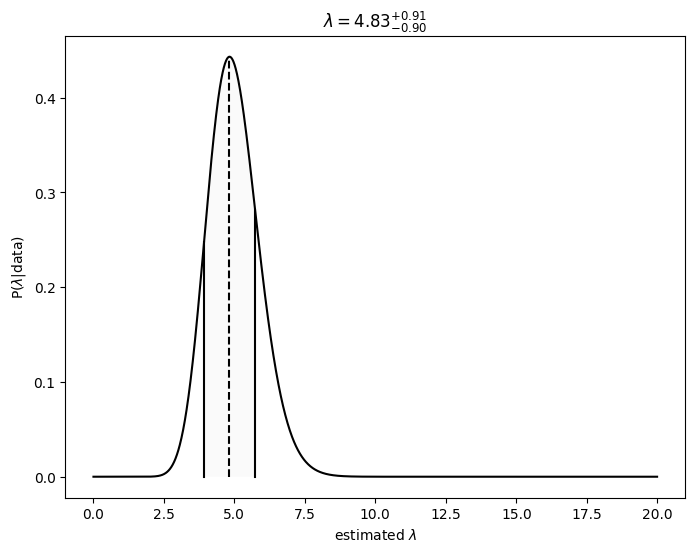

([np.float64(3.93), np.float64(4.83), np.float64(5.74)],
 array([[1.00000000e-02, 2.35472949e-66],
        [2.00000000e-02, 1.19056532e-57],
        [3.00000000e-02, 1.43331640e-52],
        ...,
        [1.99700000e+01, 1.17977109e-22],
        [1.99800000e+01, 1.12731486e-22],
        [1.99900000e+01, 1.07718317e-22]]))

In [140]:
data = [4,2,8,6,5,4]
bayesian_poiss(data)

In [141]:
grader.check("q1.1")

q1.1 results: All test cases passed!

***

<!-- BEGIN QUESTION -->

#### Problem 2 - False Positive Rate

2.1) For a given standard frequentist test you have a chance $\rho$ to recieve a false positive result (aka p-value). Imagine you run the same test many times on the same kind of data, but for different data points; for example checking if an absorption feature is significantly pressent in different stellar spectra (see figure below).<br>
<br>
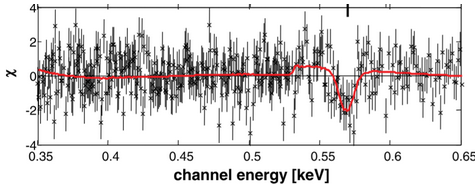

For each spectrum, you calculate the corresponding p-value.<br> 
<br>
 - Given $H_0$ is always true (no absorption feature), what would a **histogram** of these p-values look like?<br>
 - Given $H_0$ is **not always** true, what would a **histogram** of these p-values look like?<br>

- For $H_0$ always true, the histogram of p-values would a uniform distributed between 0 and 1. The reason is that if this hypothesis is true and without any priror knowledge about the data, all p-values are equally likely.
- For $H_0$ not always true, the histogram of p-values would gets higher near 0, indicating that there are more low p-values than would be expected under the null hypothesis.

<!-- END QUESTION -->

<br>

2.2) What is the probability $P$ to have **at least** $n$ false positives after $N$ tests, given $\rho$? Write a python script that generates a plot of $P$ as a function of $N$ depending on $n$ and $\rho$. The variables $N$, $n$ and $\rho$ should be the input arguments of this function. 

In [142]:
from scipy.stats import binom

def FalsePositive(N: int = 10, n: int = 1, rho: float = 0.05, plot: bool = True):
    """
    
    returns: 
        P_at_least (float): The probability described in the question statement. 
        
    """

    if n > N:
        return []

    P_vals_all = []
    for N_i in range(1, N+1):
        # P(K >= n) = 1 - P(K <= n-1) = 1 - binom.cdf(n-1, N_i, rho)
        if n > N_i:
            P_vals_all.append(0.0)
        else:
            P_vals_all.append(float(1.0 - binom.cdf(n-1, N_i, rho)))

    # Based on the test expectations, return from N = n to N (with a length of N-n+1)
    P_vals = P_vals_all[n-1:]

    if plot:
        plt.figure(figsize=(8,6))
        plt.plot(list(range(n, N+1)), P_vals, marker='o', label=f"ρ={rho}, n={n}")
        plt.xlabel("N")
        plt.ylabel(f"Probability P(K ≥ {n})")
        plt.title("Probability of at least n false positives")
        plt.grid(True)
        plt.legend()
        plt.show()

    return np.array(P_vals)

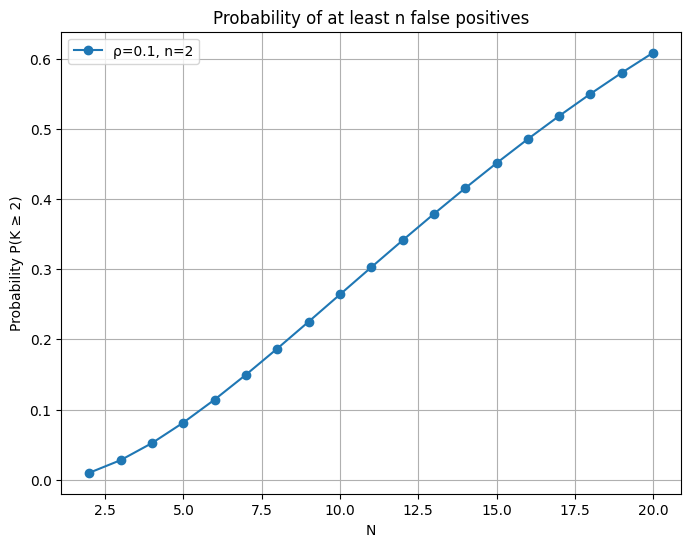

In [143]:
P = FalsePositive(N = 20, n = 2, rho = 0.1)

In [144]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Problem 3 - Fitting Data to a Straight Line (Linear Regression)

(Reference - NR 15.2) We fit a set of 50 data points $(x_i, y_i)$ to a straight-line model $y(x) = a + bx$. The uncertainty $\sigma_i$ associated with each measurement $y_i$ is known, and we assume that the $x_i$'s are known exactly. To measure how well the model agrees with the data, we use the chi-square merti function: <br>
$$ \chi^2(a,b) = \sum_{i=0}^{N-1} \big( \frac{y_i-a-bx_i}{\sigma_i} \big)^2. $$
<br>
Make a scatter plot of data (including uncertainties) and find the best-fit line. Compute the errors on the two parameters $a$ and $b$ and plot lines where the two are changed by $\pm 1\sigma$.

<br>
<span style="color:blue"> <i> 1. Plot data (make sure to include error bars). (Hint - https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.errorbar.html) </i></span><br>

In [145]:
# Load a given 2D data
data = np.loadtxt("./Problem3_data.dat")
x = data[:,0]
y = data[:,1] 
sig_y = data[:,2]

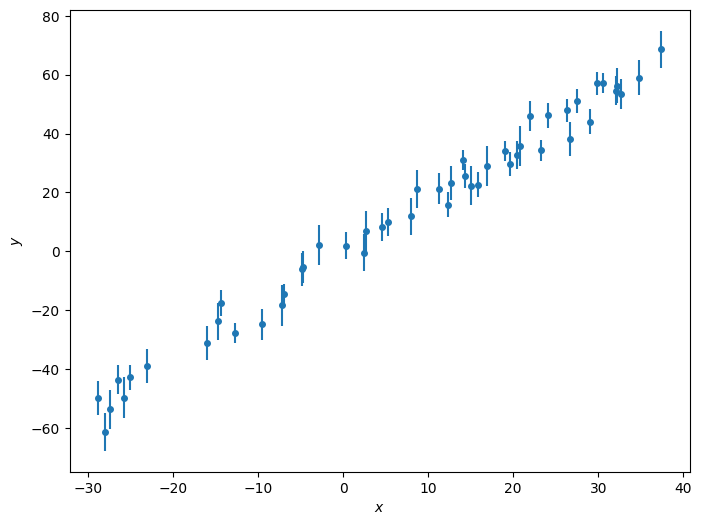

In [146]:
# Make plot
plt.figure(figsize = (8, 6))

# Scatter plot with errorbars:
plt.errorbar(x, y, yerr = sig_y, fmt = 'o', markersize = 4, label = 'Data with errorbars')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

<!-- END QUESTION -->

(NR p. 781) We should minimize the above chi-square function to determine $a$ and $b$. At its minimum, derivatives of $\chi^2$ with respect to $a, b$ vanish:
$$ \frac{\partial{\chi^2}}{\partial{a}} = -2 \sum \frac{y_i - a - bx_i}{\sigma_i^2} = 0 \ \ \ \ \ \ \ \ \ \ \ \ (1) $$
$$ \frac{\partial{\chi^2}}{\partial{b}} = -2 \sum \frac{x_i(y_i - a - bx_i)}{\sigma_i^2} = 0   \ \ \ \ \ \ \ \ \ (2) $$
<br>
These conditions can be rewritten in a convenient form if we define the following sums:
$$ S = \sum \frac{1}{\sigma_i^2},\ S_x = \sum \frac{x_i}{\sigma_i^2},\ S_y = \sum \frac{y_i}
{\sigma_i^2} $$
$$ S_{xx} = \sum \frac{x_i^2}{\sigma_i^2},\ S_{xy} = \sum \frac{x_iy_i}{\sigma_i^2} $$
<br> With these, we can rewrite (1), (2) as:
$$ a*S + b*S_x = S_y $$
$$ a*S_x + b*S_{xx} = S_{xy} $$
<br> The solution to these is calculated as:
$$ \Delta = SS_{xx} - (S_x)^2 $$ <br>
$$ a = \frac{S_{xx}S_y - S_xS_{xy}}{\Delta} $$
$$ b = \frac{SS_{xy} - S_xS_y}{\Delta} $$
<br><span style="color:blue"><i> 2. Find parameters $a, b$ which minimize the chi-square function and plot the best-fit line on top of the data. </i></span><br>

In [147]:

S = np.sum(1/sig_y**2)
Sx = np.sum(x/sig_y**2)
Sy = np.sum(y/sig_y**2)
Sxx = np.sum(x**2/sig_y**2)
Sxy = np.sum(x*y/sig_y**2)
Delta = S * Sxx - Sx**2

In [148]:
def A_(x, y, sig_y):
    # Write your definition for a here, this is required for the autograder
    return (np.sum(x**2/sig_y**2) * np.sum(y/sig_y**2) - np.sum(x/sig_y**2) * np.sum(x*y/sig_y**2)) / (np.sum(1/sig_y**2) * np.sum(x**2/sig_y**2) - (np.sum(x/sig_y**2))**2)

def B_(x, y, sig_y):
    # Write your definition for b here, this is required for the autograder
    return (np.sum(1/sig_y**2) * np.sum(x*y/sig_y**2) - np.sum(x/sig_y**2) * np.sum(y/sig_y**2)) / (np.sum(1/sig_y**2) * np.sum(x**2/sig_y**2) - (np.sum(x/sig_y**2))**2)

a = A_(x, y, sig_y)
b = B_(x, y, sig_y)


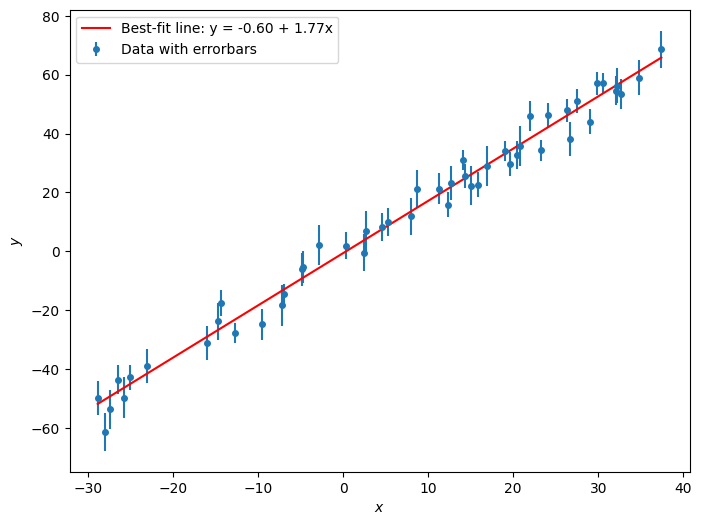

In [149]:
# Make plot
plt.figure(figsize = (8, 6))
plt.errorbar(x, y, yerr = sig_y, fmt = 'o', markersize = 4, label = 'Data with errorbars')
plt.xlabel('$x$')
plt.ylabel('$y$')
# Plot the best-fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = a + b * x_fit
plt.plot(x_fit, y_fit, 'r-', label=f'Best-fit line: y = {a:.2f} + {b:.2f}x')
plt.legend()
plt.show()

In [150]:
grader.check("q3.2")

q3.2 results: All test cases passed!

Now, we must estimate the probable uncertainties in the estimates of $a$ and $b$, since obviously the measurement errors in the data must introduce some uncertainty in the determination of those parameters. If the data are independent, then each contributes its own bit of uncertainty to the parameters. Consideration of propagation of errors show that the variance $\sigma_f^2$ in the value of any function will be
$$ \sigma_f^2 = \sum \sigma_i^2 (\frac{\partial f}{\partial y_i})^2 $$
<br> For the straight line, the derivatives of $a$ and $b$ with respect to $y_i$ can be directly evaluated from the solution:
$$ \frac{\partial a}{\partial y_i} = \frac{S_{xx}-S_x x_i}{\sigma_i^2 \Delta} $$
$$ \frac{\partial b}{\partial y_i} = \frac{S x_i-S_x}{\sigma_i^2 \Delta} $$
<br> Summing over the points, we get
$$ \sigma_a^2 = S_{xx}/\Delta $$
$$ \sigma_b^2 = S/\Delta $$

<span style="color:blue"> <i> 3. Compute the errors ($\sigma_a, \sigma_b$) on the two parameters $a, b$ and plot lines where the two are changed by $\pm 1\sigma$.</i></span><br>
(Hint - You can use plt.fill_between to shade the region between plots.)

In [151]:
# Calculate sigma_a, sigma_b


sigma_a = math.sqrt(Sxx / Delta)
sigma_b = math.sqrt(S / Delta)

print('We estimate that a =', a ,"±", sigma_a, "and b =", b, "±", sigma_b)

We estimate that a = -0.5952309466393884 ± 0.7528657804413228 and b = 1.7746965875529703 ± 0.036240121236055294


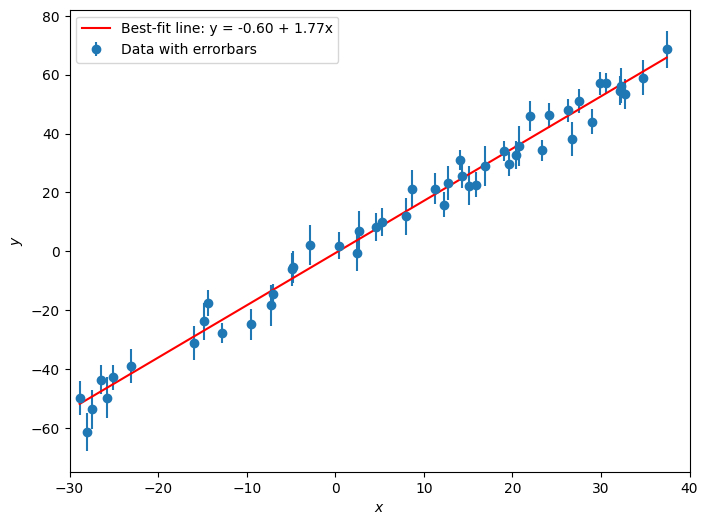

In [152]:
plt.figure(figsize = (8, 6))

plt.errorbar(x, y, yerr = sig_y, fmt = 'o', label = 'Data with errorbars')
# Plot the best-fit line
x_fit = np.linspace(min(x), max(x), 100)
y_fit = a + b * x_fit
plt.plot(x_fit, y_fit, 'r-', label=f'Best-fit line: y = {a:.2f} + {b:.2f}x')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-30, 40)
plt.legend()
plt.show()

In [153]:
grader.check("q3.3")

q3.3 results: All test cases passed!

#### Problem 4 - Central Limit Theorem

Plot the binomial distribution $P(N_A, N)$ for different values of $N$ and plot the Gaussian with mean and variance for the binomial. Similarly, plot the Poisson distribution with the mean varying from 1 to 10. See if both binomial and Poisson approach Gaussian as the mean/$N$ increases.<br><br>
(Reference - Kardar p. 41) For the binomial distribution, consider a random variable with two outcomes $A$ and $B$ of relative probabilities $p_A$ and $p_B = 1 - p_A$. The probability that in $N$ trials the event $A$ occurs exactly $N_A$ times is given by the binomial distribution:
$$ p_N(N_A) = \binom{N}{N_A} p_A^{N_A}(1-p_A)^{N-N_A}. $$
<br>
<span style="color:blue"> <i> 1. Plot the binomial distribution $P(N_A, N)$ for $N = 5, 20, 40, 100, 300$ and plot the Gaussian with mean and variance for the binomial. Let $p_A = 0.5$ and $0.1$. Make sure to label each plot.  </i></span>

In [154]:
# Import packages for the binomial coefficient
from scipy.stats import binom

# Define the probability for the binomial distribution
def pdf_binom(p_A, N, N_A):
    return binom.pmf(N_A, N, p_A)

# Define Gaussian distribution
def gaussian(x, mu, sigma):
    coeff = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    return coeff * np.exp(exponent)

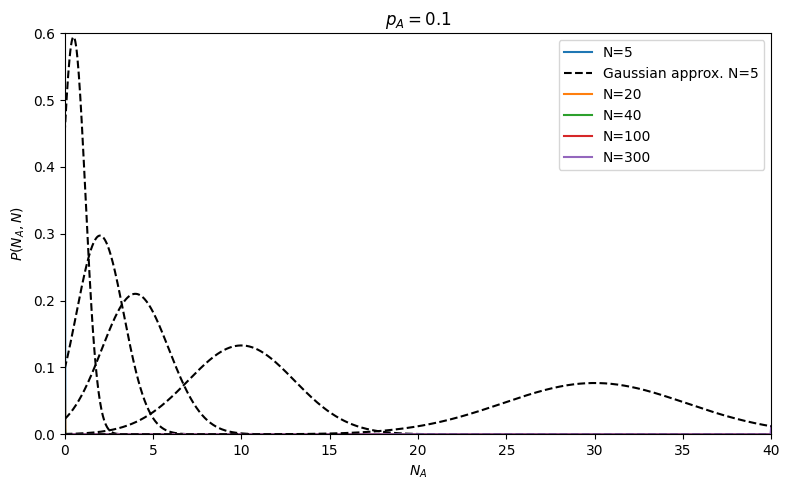

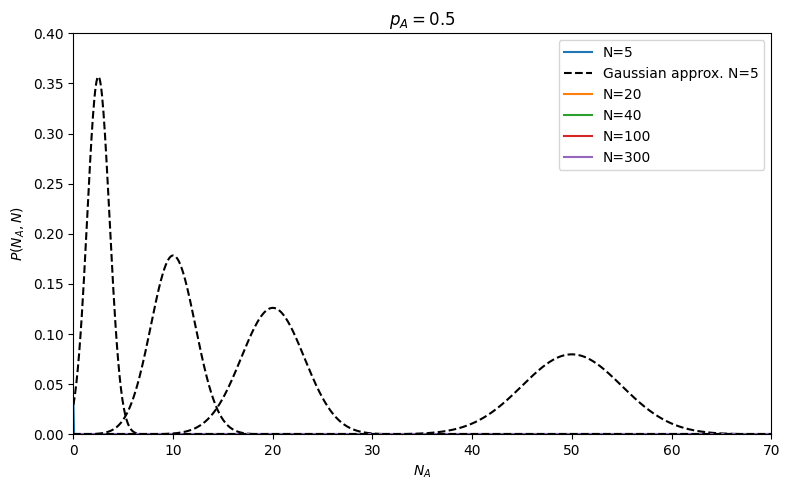

In [155]:
N = [5, 20, 40, 100, 300]
N_A = np.linspace(0, 40, 1000)

# Make plot
plt.figure(figsize= (8, 5))

# For p_A = 0.1
p_A = 0.1
for n in N:
    plt.plot(N_A, pdf_binom(p_A, n, N_A), label=f'N={n}')
    # Overlay Gaussian approximation
    mu = n * p_A
    sigma = math.sqrt(n * p_A * (1 - p_A))
    plt.plot(N_A, gaussian(N_A, mu, sigma), 'k--', label=f'Gaussian approx. N={n}' if n == N[0] else None)  
plt.xlim(0, 40)
plt.ylim(0, 0.6)
plt.xlabel('$N_A$')
plt.ylabel('$P(N_A, N)$')
plt.legend()
plt.title('$p_A = 0.1$')
plt.tight_layout()
plt.show()

N_A = np.linspace(0, 70, 1000)
plt.figure(figsize= (8, 5))
# For p_A = 0.5
p_A = 0.5
for n in N:
    plt.plot(N_A, pdf_binom(p_A, n, N_A), label=f'N={n}')
    # Overlay Gaussian approximation
    mu = n * p_A
    sigma = math.sqrt(n * p_A * (1 - p_A))
    plt.plot(N_A, gaussian(N_A, mu, sigma), 'k--', label=f'Gaussian approx. N={n}' if n == N[0] else None)
plt.xlim(0, 70)
plt.ylim(0, 0.4)
plt.xlabel('$N_A$')
plt.ylabel('$P(N_A, N)$')
plt.legend()
plt.title('$p_A = 0.5$')
plt.tight_layout()
plt.show()

In [156]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

In class, we find that the binomial distribution is approximately normal (with mean $Np_A$ and variance $Np_A(1-p_A)$) as $N \rightarrow \infty$, by the central limit theorem. The proof of this theorem can be carried out using Stirling's approximation:
$$ N! \approx N^N e^{-N}\sqrt{2\pi N} $$
<br>
<span style="color:blue"><i> 2. Plot the above Stirling's formula approximation (i.e. Compare $N!$ with Stirling's approximation. Compute the residual: (actual-estimate)/actual.) </i></span><br>
(Hint: $\Gamma(n+1) = n!$)


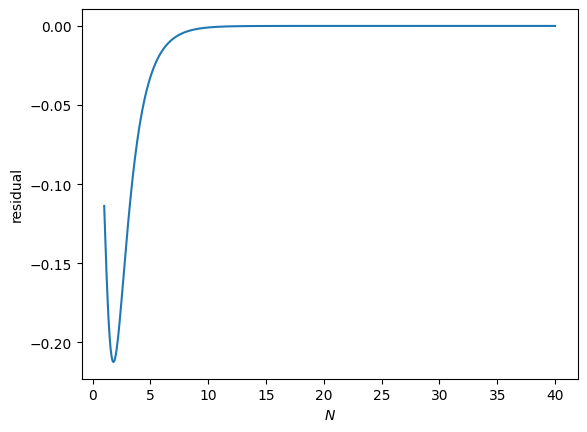

In [157]:
from scipy.special import gamma

Nvals = np.linspace(1, 40, 1000)

actual = 1 - 0.5**Nvals
estimate = 1 - gamma(Nvals + 1) * gamma(Nvals/2 + 1) / (gamma(Nvals/2 + 0.5) * gamma(2 * Nvals + 1))

plt.plot(Nvals, (actual-estimate)/actual)
plt.xlabel('$N$')
plt.ylabel('residual')
plt.show()

<!-- END QUESTION -->

You should find that residual $\rightarrow 0$ as $N \rightarrow \infty$.

Next, consider the Poisson distribution (Kardar p. 42):
$$ P(\lambda) = \frac{\lambda^k e^{-\lambda}}{k!} $$
where $k$ is the number of occurrences. Its mean and variance are $\lambda$.<br><br>
<span style="color:blue"> <i> 3. Plot $P(\lambda)$ as a function of $k$ for $\lambda = 1, 3, 5, 10, 20$ and plot the Gaussian with mean and variance for the Poisson. Make sure to label. </i></span><br>

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/var/folders/7c/kwhn06r91h57xlqx9rqvvpmm0000gn/T/ipykernel_33957/1995900570.py:16: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$P(k, \lambda)$')


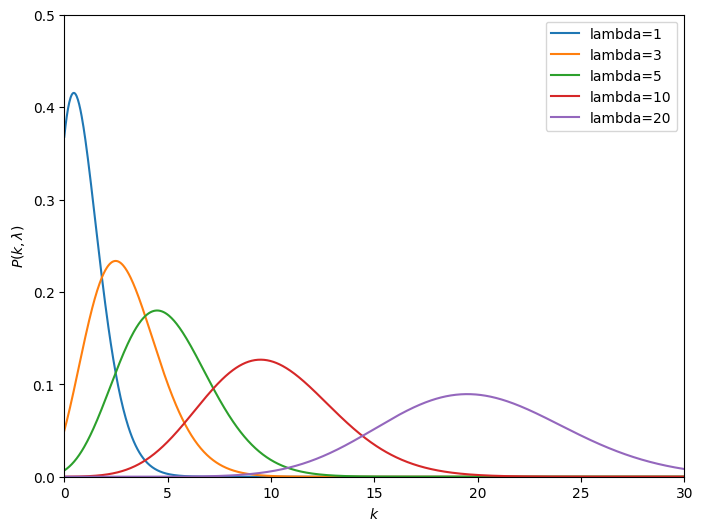

In [158]:
from scipy.special import gamma
# Define the Poisson distribution
def poisson(L, k):
    return (L**k * np.exp(-L)) / gamma(k + 1)

L = [1, 3, 5, 10, 20]
k = np.linspace(0, 30, 1000)

# Make plot
plt.figure(figsize= (8, 6))
for lam in L:
    plt.plot(k, poisson(lam, k), label=f'lambda={lam}')
plt.xlim(0, 30)
plt.ylim(0, 0.5)
plt.xlabel('$k$')
plt.ylabel('$P(k, \lambda)$')
plt.legend()
plt.show()

In [159]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<span style="color:blue"> <i> 4. What happens as the mean/$N$ increases? </i></span><br>

When the maen/$N$ increases, both the bionomial and poisson disstributions approach Gaussian distribution. This is because as the mean/$N$ increases, the distributions become more symmetric, which is exactly the definition of the Gaussian distribution. 

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

Upload the .zip file to gradescope!

In [160]:
grader.export(force_save=True, run_tests=True)

<IPython.core.display.Javascript object>

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/otter/check/notebook.py:494: UserWarning: Could not locate a PDF to include
  warnings.warn("Could not locate a PDF to include")


PandocMissing: Pandoc wasn't found.
Please check that pandoc is installed:
https://pandoc.org/installing.html